In [ ]:
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone
import os
from langchain_openai import AzureOpenAIEmbeddings
from dotenv import load_dotenv

load_dotenv()
embeddings = AzureOpenAIEmbeddings(
openai_api_type="azure",
openai_api_version=os.environ["OPENAI_API_EMBEDDING_VERSION"],
openai_api_key=os.environ["OPENAI_API_EMBEDDING_KEY"],
azure_endpoint=os.environ["AZURE_OPENAI_EMBEDDING_ENDPOINT"],
deployment=os.environ["AZURE_OPENAI_EMBEDDING_DEPLOYMENT"],
model=os.environ["AZURE_OPENAI_EMBEDDING_MODEL"],
validate_base_url=True,
)

pc = Pinecone(api_key=os.environ.get("PINECONE_API_KEY"))
from langchain.tools.retriever import create_retriever_tool
vector_store = PineconeVectorStore(index=pc.Index("langstuffindex"), embedding=embeddings)

d:\agentagent\AgentAgent\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [76]:
from langchain.tools.retriever import create_retriever_tool
retriever = vector_store.as_retriever()

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_agent_info",
    "Search and return information about Langchain, langgraphs, model-context-protocol, examples of multiagent systems, and other related topics.",
)

tools = [retriever_tool]

In [2]:
stategraph = """
stategraph:
  state:
    OverallState:
      type: TypedDict
      fields:
      - name: input
        type: str
      - name: plan
        type: List[str]
      - name: past_steps
        type: List[Tuple]
      - name: response
        type: str
      - name: messages
        type: Annotated[list[AnyMessage], add_messages]
    config_schema:
      type: TypedDict
      fields:
        llm: str
  nodes:
    - name: START
      function: null
    - name: END
      function: null
    - name: planner
      function: plan_step 
      input_state: OverallState
      output_state: OverallState
      description: "Plan step generates a plan based on the input using llm structured output functionality, stores it to the plan field"
    - name: agent
      function: execute_step
      input_state: OverallState
      output_state: OverallState
      description: "Agent step executes the plan and appends the result to the past_steps field"
    - name: replan
      function: replan_step
      input_state: OverallState
      output_state: OverallState
      description: "Replan step uses structured output llm functionality, if the plan is finished, the step llm returns a Response, else it returns a Plan object."
  edges:
    - from: START
      to: planner
    - from: planner
      to: agent
    - from: agent
      to: replan
  conditional_edges:
    - from: replan
      routing_function: should_end
      mapping:
        END: "If response is present and set in state"
        agent: "If response is not present or set in state"
"""

In [43]:
from bs4 import BeautifulSoup
import html2text
import httpx


def fetch_documents(url: str) -> str:
    """Fetch a document from a URL and return the markdownified text.

    Args:
        url (str): The URL of the document to fetch.

    Returns:
        str: The markdownified text of the document.
    """
    httpx_client = httpx.Client(follow_redirects=True, timeout=10)

    try:
        response = httpx_client.get(url, timeout=10)
        response.raise_for_status()
        html_content = response
        soup = BeautifulSoup(html_content, 'html.parser')
       
        img_tags = soup.find_all('img')
        for img_tag in img_tags:
            img_tag.decompose()

        target_div = soup.find('div', class_= "theme-doc-markdown markdown") #langchain
        
        if not target_div:
            target_div = soup.find('article') #langraph
        
        if not target_div:
            target_div = soup.find('html') #langraph
        
        if not target_div:
            return html2text.html2text(str(soup))
        
        return html2text.html2text(str(target_div))
    except (httpx.HTTPStatusError, httpx.RequestError) as e:
        return f"Encountered an HTTP error: {str(e)}"

Trying to recreate stategraph boiler plate based on glossary only

In [21]:
from langchain import hub
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import create_react_agent

# Choose the LLM that will drive the agent
llm = ChatOpenAI(model="gpt-4o-mini")
prompt = "You are a helpful assistant."
agent_executor = create_react_agent(llm, tools, prompt=prompt)

In [ ]:
from pydantic import BaseModel, Field
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict
from langchain_core.prompts import ChatPromptTemplate
from typing import Union
from typing import Literal
from langgraph.graph import END
from langgraph.graph import StateGraph, START


class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )
    

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | ChatOpenAI(
    model="gpt-4o-mini", temperature=0
).with_structured_output(Plan)



class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = replanner_prompt | ChatOpenAI(
    model="gpt-4o-mini", temperature=0
).with_structured_output(Act)


async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"
    

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)
# Add the execution step
workflow.add_node("agent", execute_step)
# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")
# From plan we go to agent
workflow.add_edge("planner", "agent")
# From agent, we replan
workflow.add_edge("agent", "replan")
workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
    ["agent", END],
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

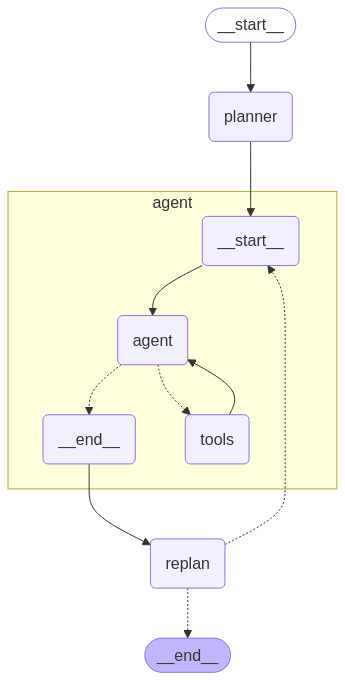

In [ ]:
from IPython.display import Image, display
-
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
NODE_INFO_PROMPT =ChatPromptTemplate.from_template("""
User query: You are supposed to generate a node for the langgraph framework.
You are provided with the following information about the node:
The schema information is as follows: {schema_info}
The input schema is: {input_schema}
The output schema is: {output_schema}
The description of the function is: {description}
The function name is: {function_name}
""")

for output in agent.stream({
  "messages": [HumanMessage(content = NODE_INFO_PROMPT.format(schema_info="""
OverallState:
      type: TypedDict
      fields:
      - name: input
        type: str
      - name: plan
        type: List[str]
      - name: past_steps
        type: List[Tuple]
      - name: response
        type: str
      - name: messages
        type: Annotated[list[AnyMessage], add_messages]""",
        input_schema="OverallState",
        output_schema="OverallState",
        description="Plan step generates a plan based on the input using llm structured output functionality, stores it to the plan field",
        function_name="planner"))]
      }, stream_mode="updates"):
        last_message = next(iter(output.values()))["messages"][-1]
        last_message.pretty_print()

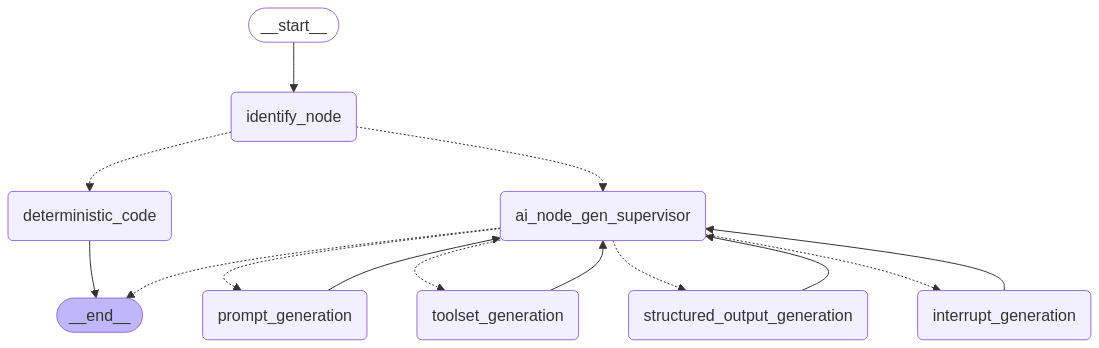

In [ ]:
from langgraph.graph import StateGraph, START
class NodeBuilderState(MessagesState):
    """State for the node builder."""
    schema_info: str = Field(description="Schema information about the node")
    input_schema: str = Field(description="Input schema of the node")
    output_schema: str = Field(description="Output schema of the node")
    description: str = Field(description="Description of the node")
    function_name: str = Field(description="Function name of the node")
    code: str = Field(description="Code for the node")
    toolset: list[str] = Field(description="List of tools to be used in the node by the llm")
    node_type : str = Field(description="Type of node, deterministic if the function is deterministic and requires simple python code generation, ai if the function is not deterministic and requires a llm usage for meeting the requirements")
    pass

def identify_node(state: NodeBuilderState):
    """Identify the node and return the information."""
    # Extract the information from the state
    llm_with_structured_output = llm.with_structured_output(NodeType)
    prompt = ChatPromptTemplate.from_template(
        """You are supposed to suggest a toolset for implementing the function {function_name}. 
You are provided with the following information about the node:
The schema information is as follows: {schema_info}
The input schema is: {input_schema}
The output schema is: {output_schema}
The description of the function is: {description}

The resultant list can contain the description of what the tool does
You are only supposed to return a simple list of tool descriptions, no other information is needed.
""")
    type_of_node = llm_with_structured_output.invoke(prompt.format(
        schema_info=state["schema_info"],
        input_schema=state["input_schema"],
        output_schema=state["output_schema"],
        description=state["description"],
        function_name=state["function_name"]))
    return {"node_type": type_of_node.node_type}

def deterministic_code_gen(state: NodeBuilderState):
    """Generate the code for the node."""
    prompt = ChatPromptTemplate.from_template(
        """Generate the python code for the function {function_name}.
You are provided with the following information about the node:
The schema information is as follows: {schema_info}
The input schema is: {input_schema}
The output schema is: {output_schema}
The description of the function is: {description}

Implement the function to meet the requirements.
""")
    code = llm.invoke(prompt.format(
        schema_info=state["schema_info"],
        input_schema=state["input_schema"],
        output_schema=state["output_schema"],
        description=state["description"],
        function_name=state["function_name"]))
    return {"code": code.content}


def ai_node_gen_supervisor(state: NodeBuilderState):
    """Generate the code for the node."""
    pass

def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""

        next: Literal[*options]

    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            goto = END

        return Command(goto=goto, update={"next": goto})

    return supervisor_node


def prompt_generation(state: NodeBuilderState):
    """Generate the code for the node."""
    pass

def toolset_generation(state: NodeBuilderState):
    """Generate the code for the node."""
    llm_with_structured_output = llm.with_structured_output(list[str])
    prompt = ChatPromptTemplate.from_template(
        """You are supposed to suggest a toolset for implementing the function {function_name}. 
You are provided with the following information about the node:
The schema information is as follows: {schema_info}
The input schema is: {input_schema}
The output schema is: {output_schema}
The description of the function is: {description}

The resultant list can contain the description of what the tool does
You are only supposed to return a simple list of tool descriptions, no other information is needed.
""")
    
    toolset = llm_with_structured_output.invoke(prompt.format(
        schema_info=state["schema_info"],
        input_schema=state["input_schema"],
        output_schema=state["output_schema"],
        description=state["description"],
        function_name=state["function_name"]))
    return {"toolset": toolset}

def structured_output_generation(state: NodeBuilderState):
    """Generate the code for the node."""
    pass

def interrupt_generation(state: NodeBuilderState):
    """Generate the code for the node."""
    pass


class NodeType(BaseModel):
    node_type: Literal["deterministic", "ai"] = Field(description="Type of node, deterministic if the function is deterministic and requires simple python code generation, ai if the function is not deterministic and requires a llm usage for meeting the requirements")
    
def determine_node_type(state: NodeBuilderState):
    """Determine the type of node."""
    node_type: str = state["node_type"]
    if node_type == "deterministic":
        return "deterministic_code"
    elif node_type == "ai":
        return "ai_node_gen_supervisor"

def determine_action(state: NodeBuilderState):
    """Determine the action to take."""
    pass

workflow = StateGraph(NodeBuilderState)
workflow.add_node("identify_node", identify_node)
workflow.add_node("deterministic_code", deterministic_code_gen)
workflow.add_node("ai_node_gen_supervisor", ai_node_gen_supervisor)
workflow.add_node("prompt_generation", prompt_generation)
workflow.add_node("toolset_generation", toolset_generation)
workflow.add_node("structured_output_generation", structured_output_generation)
workflow.add_node("interrupt_generation", interrupt_generation)


workflow.add_edge(START, "identify_node")
workflow.add_conditional_edges("identify_node", determine_node_type, ["deterministic_code", "ai_node_gen_supervisor"])
workflow.add_edge("deterministic_code", END)
workflow.add_conditional_edges("ai_node_gen_supervisor", determine_action, ["prompt_generation", "toolset_generation", "structured_output_generation", "interrupt_generation", END])
workflow.add_edge("prompt_generation", "ai_node_gen_supervisor")
workflow.add_edge("toolset_generation", "ai_node_gen_supervisor")
workflow.add_edge("structured_output_generation", "ai_node_gen_supervisor")
workflow.add_edge("interrupt_generation", "ai_node_gen_supervisor")

app = workflow.compile()
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
# Role and Objective

# Instructions

## Sub-categories for more detailed instructions

# Reasoning Steps

# Output Format

# Examples
## Example 1

# Context

# Final instructions and prompt to think step by step